In [1]:
"""
data load

"""

import cv2
import os
import numpy as np
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import natsort


def load_data(PATH, split=0.21):
    images = natsort.natsorted(glob(os.path.join(PATH, "/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/*")))
    masks = natsort.natsorted(glob(os.path.join(PATH, "/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_masks_single/*")))

    print(images)
    print(masks)

    total_size = len(images)
    total_mask_size = len(masks)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    print("total_number_of_images:", total_size)
    
    print("total_mask_images:", total_mask_size)
    print("valid_size:", valid_size)
    print("test_size:", test_size)


    train_x, valid_x = train_test_split(
             images,
             test_size=valid_size,
             random_state=42
     )
    train_y, valid_y = train_test_split(
             masks,
             test_size=valid_size,
             random_state=42
     )

    train_x, test_x = train_test_split(
             images,
             test_size=test_size,
             random_state=42
     )
    train_y, test_y = train_test_split(
             masks,
             test_size=test_size,
             random_state=42
     )

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


def read_image(PATH):
     PATH = PATH.decode()
     x = cv2.imread(PATH, cv2.IMREAD_COLOR)
     x = cv2.resize(x, (128, 128))
     x = x/255.0
     return x


def read_mask(PATH):
     PATH = PATH.decode()
     x = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)
     x = cv2.resize(x, (128, 128))
     x = x/255.0
     x = np.expand_dims(x, axis=-1)
     return x


def tf_parse(sx, sy):
     def _parse(x, y):
         x = read_image(x)
         y = read_mask(y)
         return x, y

     sx, sy = tf.numpy_function(_parse, [sx, sy], [tf.float64, tf.float64])
     sx.set_shape([128, 128, 3])
     sy.set_shape([128, 128, 1])
     return sx, sy


def tf_dataset(x, y, batch=8):
     dataset = tf.data.Dataset.from_tensor_slices((x, y))
     dataset = dataset.map(tf_parse)
     dataset = dataset.batch(batch)
     dataset = dataset.repeat()
     return dataset


if __name__ == "__main__":
     PATH = "/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/datasets/"
     (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

     print("Training data x: ", len(train_x))
     print("Training data y: ", len(train_y))
     print("Validation data x: ", len(valid_x))
     print("Validation data y: ", len(valid_y))
     print("Testing data x: ", len(test_x))
     print("Testing data y: ", len(test_y))
     print(" ")

     ds = tf_dataset(test_x, test_y)
     for x, y in ds:
         print("textx shape:",x.shape,"|","testy shape:", y.shape)
         break
   

['/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_0.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_1.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_2.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_3.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_4.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_5.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_6.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_7.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_8.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resiz

In [ ]:
"""
images = sorted(glob(os.path.join(PATH, "/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/*")))
masks = sorted(glob(os.path.join(PATH, "/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_masks_single/*")))

total_size = len(images)
total_mask_size = len(images)

print("total_size:", total_size)
print("total_mask_size:", total_mask_size)

 
i=0
for i  in range(0, 3000):
   image_name = images.rsplit('.', 1)[i]  # returns 'image'
   mask_name = masks.rsplit('.', 1)[i]  # return 'mask'

   if image_name == mask_name:  # This is True for this exact case
     print('match')
   else:
     print('didnot match') 
     """

In [2]:
"""
create model

"""

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, MaxPool2D
from tensorflow.keras.models import Model


def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def build_model():
    size = 128
    num_filters = [16, 32, 48, 64]
    inputs = Input(shape=(size, size, 3))

    skip_x = []
    x = inputs

    # Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    # Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    # Decoder
    for i, f, in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    # Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)


if __name__ == "__main__":
    billboard_unet_model = build_model()
    billboard_unet_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
#train

import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.callbacks import (
        EarlyStopping,
        ModelCheckpoint,
        ReduceLROnPlateau,
        CSVLogger,
        TensorBoard
)
from tensorflow.keras.metrics import Recall, Precision
#from Data import load_data, tf_dataset
#from Model import build_model

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


if __name__ == "__main__":
    PATH = "/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/datasets/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

    BATCH = 8
    lr = 1e-4
    epochs = 50

    train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

    billboard_unet_model = build_model()
    opt = tf.keras.optimizers.Adam(lr)
    metrics = ["acc", Recall(), Precision(), iou]
    billboard_unet_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

    callbacks = [
        ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/model/unet_model.h5"), #saves best model according to val_loss
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3),
        CSVLogger("/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/csv_data/unet_data.csv"),#epoch results to a csv file
        TensorBoard(),
        EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=False
        )
    ]

    train_steps = len(train_x) // BATCH
    valid_steps = len(valid_x) // BATCH

    if len(train_x) % BATCH != 0:
        train_steps += 1
    if len(valid_x) % BATCH != 0:
        valid_steps += 1

    model_history= billboard_unet_model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps
        #callbacks=callbacks
    )

['/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_0.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_1.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_2.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_3.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_4.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_5.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_6.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_7.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_8.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resiz

In [ ]:
#evaluate testing image #epochs 25
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = len(test_x) // BATCH

if len(test_x) % BATCH != 0:
    test_steps += 1

billboard_unet_model.evaluate(test_dataset, steps=test_steps)

102/102 [==============================] - 8s 80ms/step - loss: 0.0953 - acc: 0.9649 - recall: 0.7736 - precision: 0.9159 - iou: 0.6596


[0.09529712796211243,
 0.9648932814598083,
 0.7735620141029358,
 0.9158869385719299,
 0.6595872044563293]

In [ ]:
#evaluate testing image
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = len(test_x) // BATCH

if len(test_x) % BATCH != 0:
    test_steps += 1

billboard_unet_model.evaluate(test_dataset, steps=test_steps)

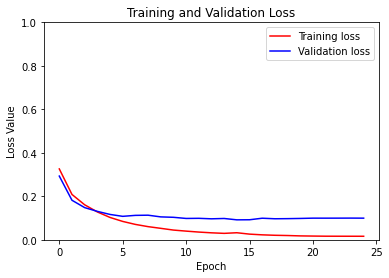

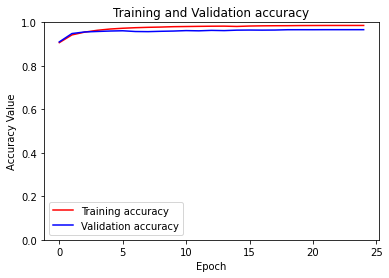

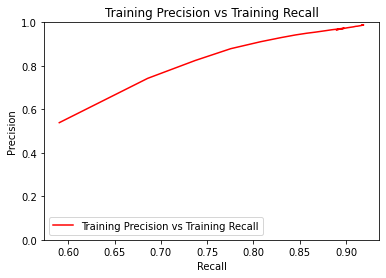

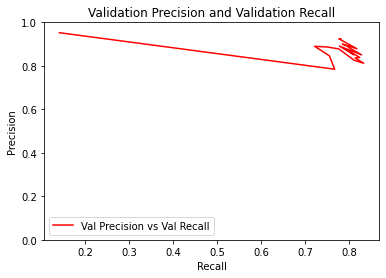

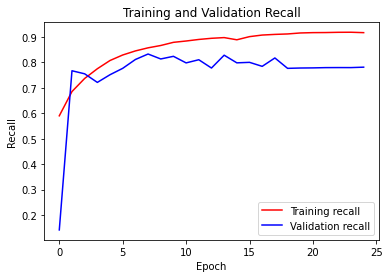

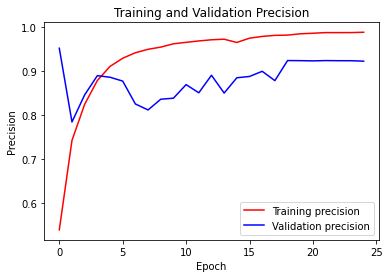

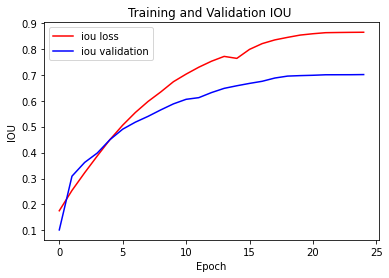

In [ ]:
from matplotlib import gridspec
import matplotlib.pyplot as plt

epoch = 25
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(epoch)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
#cmap = plt.cm.jet
plt.savefig('/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/loss_acc_plot/Training_Validation_Loss.jpg')#, cmap=cmap)
plt.show()

accuracy = model_history.history['acc']
val_accuracy = model_history.history['val_acc']

#epochs = range(epoch)

plt.figure()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
#cmap = plt.cm.jet
plt.savefig('/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/loss_acc_plot/Training_Validation_Accuracy.jpg')#, cmap=cmap)
plt.show()

rec = model_history.history['recall']
prec = model_history.history['precision']
rec_acc = model_history.history['val_recall']
prec_acc = model_history.history['val_precision']

plt.figure()
#gs=gridspec.GridSpec(1, 2, width_ratios=[5,5])
#plt.subplot(gs[0])
plt.plot(rec, prec, 'r', label='Training Precision vs Training Recall')
plt.title('Training Precision vs Training Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/loss_acc_plot/Precision_Recall_Loss.jpg')#, cmap=cmap)
plt.show()

plt.figure()
#plt.subplot(gs[1])
plt.plot(rec_acc, prec_acc, 'r', label='Val Precision vs Val Recall')
plt.title('Validation Precision and Validation Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/loss_acc_plot/Precision_Recall_Accuracy.jpg')#, cmap=cmap)
plt.show()

plt.figure()
#gs1=gridspec.GridSpec(1,2,width_ratios=[5,5])
#plt.subplot(gs[0])
plt.plot(epochs, rec, 'r', label='Training recall')
plt.plot(epochs, rec_acc, 'b', label='Validation recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/loss_acc_plot/Training_Valdidation_Recall.jpg')
plt.show()

plt.figure()
#plt.subplot(gs[1])
plt.plot(epochs, prec, 'r', label='Training precision')
plt.plot(epochs, prec_acc,'b', label = 'Validation precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/loss_acc_plot/Training_Valdidation_Precision.jpg')
plt.show()

iou = model_history.history['iou']
val_iou = model_history.history['val_iou']

plt.figure()
plt.plot(epochs, iou, 'r', label='iou loss')
plt.plot(epochs, val_iou, 'b', label='iou validation')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.title('Training and Validation IOU ')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/loss_acc_plot/Training_Valdidation_IOU.jpg')
plt.show()

In [ ]:
#save model
billboard_unet_model.save('/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/model/billboard_unet_seg.hdf5')

In [ ]:

#predict

import os
import cv2
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from keras.utils import CustomObjectScope
#from Data import load_data, tf_dataset
#from Train import iou
import matplotlib.pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def read_image(PATH):
    x = cv2.imread(PATH, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (128, 128))
    '''
    img_name_location = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_2623.jpg'
    original_img = load_img(img_name_location)
    resizedwidth=dims[0]
    wpercent = (resizedwidth/float(original_img.size[0]))
    resizedheight = int((float(original_img.size[0])*float(wpercent)))
    resized_img = original_img.resize((resizedwidth,resizedheight), Image.ANTIALIAS)
    array_img = img_to_array(resized_img)/255
    '''
    print("x shape:",x.shape)
    x = x/255.0
    return x


def read_mask(PATH):
    x = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (128, 128))
    print("y shape:",x.shape)
    #x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x


def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask


if __name__ == "__main__":
    np.random.seed(42)
    tf.random.set_seed(42)

    PATH = "/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/datasets/"
    BATCH = 8

    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

    test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
    test_steps = len(test_x) // BATCH
    print("test steps:", test_steps)
    print("len of testx:", len(test_x))
    print("len of testy:", len(test_y))

    if len(test_x) % BATCH != 0:
        test_steps += 1

    with CustomObjectScope({'iou': iou}):
       #model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/model/billboard_unet_seg.hdf5")
       model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/model/unet_model.h5")
    #model.evaluate(test_dataset, steps=test_steps)
    #results = model.evaluate(test_x, test_y, batch_size=8)
    #print("test loss, test acc:", results)


    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        x = read_image(x)
        y = read_mask(y)
        #test_image = np.expand_dims(x, axis=0)
        #show_test_image = np.squeeze(test_image)
        #decoded_img = model.predict(test_image)
        #show_decoded_image = np.squeeze(decoded_img)
        y_pred = model.predict(np.expand_dims(x, axis=0))
       # y_pred = np.squeeze(y_pred)
        y_pred = y_pred[0] > 0.5
        #cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/unet_results/Results_{i}.png", y_pred)
        plt.savefig("/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/unet_results/Results_{i}.png")

        # cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/results/original/scene_{i}.png", x)
        # cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/results/mask/scene_{i}.png", y)
        # cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/results/predictedmask/scene_pred_{i}.png", y_pred)

'''
        h, w, _ = x.shape

        white_line = np.ones((h, 10, 3)) * 255.0
        all_images = [
                x * 255.0, white_line,
                mask_parse(y), white_line,
                mask_parse(y_pred) * 255.0
        ]
        image = np.concatenate(all_images, axis=0)
        cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/unet_results/Results_{i}.png", image)
'''
        


['/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_0.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_1.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_2.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_3.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_4.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_5.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_6.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_7.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_8.jpg', '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resiz

ValueError: ignored

1/1 [==============================] - 0s 17ms/step


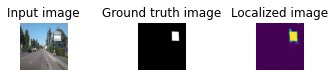

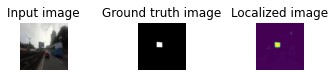

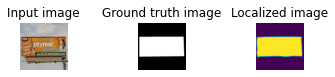

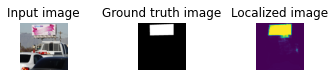

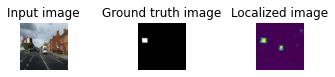

In [ ]:
#predict

from keras.models import load_model
import h5py
from tensorflow.keras.utils import img_to_array, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import matplotlib.pyplot as plt
from random import randrange
from PIL import Image
from keras.utils import CustomObjectScope


with CustomObjectScope({'iou': iou}):
 unetModel = load_model("/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/model/billboard_unet_seg.hdf5")
 #unetModel = load_model("/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/model/unet_model.h5")
dims = [128,128] #dimension

img_name_location = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_2623.jpg'
original_img = load_img(img_name_location)
#print(original_img.size)#(512, 512)
#print("width:", original_img.size[0])#512
#print("height:",original_img.size[1])#512
resizedwidth=dims[0]#0.25
wpercent = (resizedwidth/float(original_img.size[0]))
resizedheight = int((float(original_img.size[0])*float(wpercent)))
#print(wpercent)
#print("resizedwidth:",resizedwidth)#128
#print("resizedheight:",resizedheight)#128
resized_img = original_img.resize((resizedwidth,resizedheight), Image.ANTIALIAS)
array_img = img_to_array(resized_img)/255


mask_name_location = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_masks_single/scene_2623.jpg'
original_mask = load_img(mask_name_location)
resized_mask = original_mask.resize((resizedwidth,resizedheight), Image.ANTIALIAS)
array_mask = img_to_array(resized_mask)/255

test_image = np.expand_dims(array_img, axis=0)
show_test_image = np.squeeze(test_image)

decoded_img = unetModel.predict(test_image)
show_decoded_image = np.squeeze(decoded_img)

#-------------2nd set-------------------#


img_name_location1 = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_2687.jpg'
original_img1 = load_img(img_name_location1)
#print(original_img1.size)
#print("width:", original_img1.size[0])
#print("height:",original_img1.size[1])
resizedwidth1=dims[0]
wpercent1 = (resizedwidth1/float(original_img1.size[0]))
resizedheight1 = int((float(original_img1.size[0])*float(wpercent1)))
#print(wpercent1)
#print("resizedwidth:",resizedwidth1)
#print("resizedheight:",resizedheight1)
resized_img1 = original_img1.resize((resizedwidth1,resizedheight1), Image.ANTIALIAS)
array_img1 = img_to_array(resized_img1)/255


mask_name_location1 = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_masks_single/scene_2687.jpg'
original_mask1 = load_img(mask_name_location1)
resized_mask1 = original_mask1.resize((resizedwidth1,resizedheight1), Image.ANTIALIAS)
array_mask1 = img_to_array(resized_mask1)/255

test_image1 = np.expand_dims(array_img1, axis=0)
show_test_image1 = np.squeeze(test_image1)

decoded_img1 = unetModel.predict(test_image1)
show_decoded_image1 = np.squeeze(decoded_img1)

#-------------3rd set-------------------#


img_name_location2 = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_104.jpg'
original_img2 = load_img(img_name_location2)
#print(original_img1.size)
#print("width:", original_img1.size[0])
#print("height:",original_img1.size[1])
resizedwidth2=dims[0]
wpercent2 = (resizedwidth2/float(original_img2.size[0]))
resizedheight2 = int((float(original_img2.size[0])*float(wpercent2)))
#print(wpercent1)
#print("resizedwidth:",resizedwidth1)
#print("resizedheight:",resizedheight1)
resized_img2 = original_img2.resize((resizedwidth2,resizedheight2), Image.ANTIALIAS)
array_img2 = img_to_array(resized_img2)/255


mask_name_location2 = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_masks_single/scene_104.jpg'
original_mask2 = load_img(mask_name_location2)
resized_mask2 = original_mask2.resize((resizedwidth2,resizedheight2), Image.ANTIALIAS)
array_mask2 = img_to_array(resized_mask2)/255

test_image2 = np.expand_dims(array_img2, axis=0)
show_test_image2 = np.squeeze(test_image2)

decoded_img2 = unetModel.predict(test_image2)
show_decoded_image2 = np.squeeze(decoded_img2)


#-------------4th set-------------------#


img_name_location3 = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_139.jpg'
original_img3 = load_img(img_name_location3)
#print(original_img1.size)
#print("width:", original_img1.size[0])
#print("height:",original_img1.size[1])
resizedwidth3=dims[0]
wpercent3= (resizedwidth2/float(original_img3.size[0]))
resizedheight3 = int((float(original_img3.size[0])*float(wpercent3)))
#print(wpercent1)
#print("resizedwidth:",resizedwidth1)
#print("resizedheight:",resizedheight1)
resized_img3 = original_img3.resize((resizedwidth3,resizedheight3), Image.ANTIALIAS)
array_img3 = img_to_array(resized_img3)/255


mask_name_location3 = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_masks_single/scene_139.jpg'
original_mask3 = load_img(mask_name_location3)
resized_mask3 = original_mask3.resize((resizedwidth3,resizedheight3), Image.ANTIALIAS)
array_mask3 = img_to_array(resized_mask3)/255

test_image3 = np.expand_dims(array_img3, axis=0)
show_test_image3 = np.squeeze(test_image3)

decoded_img3 = unetModel.predict(test_image3)
show_decoded_image3 = np.squeeze(decoded_img3)

#-------------5th set-------------------#


img_name_location4 = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/scene_3872.jpg'
original_img4 = load_img(img_name_location4)
#print(original_img1.size)
#print("width:", original_img1.size[0])
#print("height:",original_img1.size[1])
resizedwidth4=dims[0]
wpercent4= (resizedwidth4/float(original_img4.size[0]))
resizedheight4 = int((float(original_img4.size[0])*float(wpercent4)))
#print(wpercent1)
#print("resizedwidth:",resizedwidth1)
#print("resizedheight:",resizedheight1)
resized_img4 = original_img4.resize((resizedwidth4,resizedheight4), Image.ANTIALIAS)
array_img4 = img_to_array(resized_img4)/255


mask_name_location4 = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_masks_single/scene_3872.jpg'
original_mask4 = load_img(mask_name_location4)
resized_mask4 = original_mask4.resize((resizedwidth4,resizedheight4), Image.ANTIALIAS)
array_mask4 = img_to_array(resized_mask4)/255

test_image4 = np.expand_dims(array_img4, axis=0)
show_test_image4 = np.squeeze(test_image4)

decoded_img4 = unetModel.predict(test_image4)
show_decoded_image4 = np.squeeze(decoded_img4)




#plt.figure(1)
plt.subplot(431)
plt.imshow(array_img)
plt.axis('off')
plt.title('Input image')
#plt.show()


#plt.figure(2)
plt.subplot(432)
plt.imshow(array_mask)
plt.axis('off')
plt.title('Ground truth image')
#plt.show()


#plt.figure(3)
plt.subplot(433)
plt.imshow(show_decoded_image)
plt.axis('off')
plt.title('Localized image')
plt.show()
#cmap = plt.cm.jet

#------2nd set ----#

#plt.figure(1)
plt.subplot(431)
plt.imshow(array_img1)
plt.axis('off')
plt.title('Input image')
#plt.show()


#plt.figure(2)
plt.subplot(432)
plt.imshow(array_mask1)
plt.axis('off')
plt.title('Ground truth image')
#plt.show()


#plt.figure(3)
plt.subplot(433)
plt.imshow(show_decoded_image1)
plt.axis('off')
plt.title('Localized image')
plt.show()

#------3rd set ----#

#plt.figure(1)
plt.subplot(431)
plt.imshow(array_img2)
plt.axis('off')
plt.title('Input image')
#plt.show()


#plt.figure(2)
plt.subplot(432)
plt.imshow(array_mask2)
plt.axis('off')
plt.title('Ground truth image')
#plt.show()


#plt.figure(3)
plt.subplot(433)
plt.imshow(show_decoded_image2)
plt.axis('off')
plt.title('Localized image')
plt.show()

#------4th set ----#

#plt.figure(1)
plt.subplot(431)
plt.imshow(array_img3)
plt.axis('off')
plt.title('Input image')
#plt.show()


#plt.figure(2)
plt.subplot(432)
plt.imshow(array_mask3)
plt.axis('off')
plt.title('Ground truth image')
#plt.show()


#plt.figure(3)
plt.subplot(433)
plt.imshow(show_decoded_image3)
plt.axis('off')
plt.title('Localized image')
plt.show()

#------5th set ----#

#plt.figure(1)
plt.subplot(431)
plt.imshow(array_img4)
plt.axis('off')
plt.title('Input image')
#plt.show()


#plt.figure(2)
plt.subplot(432)
plt.imshow(array_mask4)
plt.axis('off')
plt.title('Ground truth image')
#plt.show()


#plt.figure(3)
plt.subplot(433)
plt.imshow(show_decoded_image4)
plt.axis('off')
plt.title('Localized image')
plt.show()




In [ ]:
#predict

from keras.models import load_model
import h5py
from tensorflow.keras.utils import img_to_array, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import matplotlib.pyplot as plt
from random import randrange
from PIL import Image
from keras.utils import CustomObjectScope
import glob
import natsort

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

with CustomObjectScope({'iou': iou}):
 unetModel = load_model("/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/model/billboard_unet_seg.hdf5")
 #unetModel = load_model("/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/model/unet_model.h5")
dims = [128,128] #dimension


class saveimg(object):

  def __init__(self,images):
     self.images = images
     

  def originalimg(self):
    #self.org_array = []
    self.pred_array = []
    resizedwidth=dims[0]#0.25
    wpercent = 128 #(resizedwidth/float(self.images.size[0]))
    resizedheight = 128 #int((float(self.images.size[0])*float(wpercent))) 
    for i in range(len(self.images)):
      self.resized_img = cv2.resize(self.images[i],(128,128))
         #resized_img = self.images[i].resize((resizedwidth,resizedheight), Image.ANTIALIAS)
      self.array_img = img_to_array(self.resized_img)/255
         #self.org_array.append(array_img)
      self.test_image = np.expand_dims(self.array_img, axis=0)
      self.show_test_image = np.squeeze(self.test_image)
      self.decoded_img = unetModel.predict(self.test_image)
      self.show_decoded_image = np.squeeze(self.decoded_img)
      #print(self.show_decoded_image.shape)
      self.show_decoded_image = cv2.resize(self.show_decoded_image,(512,512))
      #print(self.show_decoded_image.shape)
      self.pred_array.append(self.show_decoded_image)

      '''
      plt.subplot(121)
      plt.gca().set_title("Original")
      plt.imshow(self.images[0])
      plt.xticks([]), plt.yticks([])

      plt.subplot(122)
      plt.gca().set_title("predicted unet image")
      plt.imshow(self.pred_array[0], cmap='gray')
      plt.xticks([]), plt.yticks([])
      plt.show()
   '''

  def writesegment(self, OUTDIR):
    print("predicted image lenght:",len(self.pred_array))
    for i in range(len(self.pred_array)):
        plt.imsave(OUTDIR +
                    "Result_" +
                    str(i) +
                    ".jpg",
                    self.pred_array[i], cmap="Greys_r"
            )
       # plt.imshow(self.pred_array[i], cmap='gray')
       # plt.xticks([]), plt.yticks([])
       # plt.show()

if __name__ == "__main__":

  img_name_location = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_images_single/'
  OUTDIR = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_unet_seg/unet_results/'
#mask_name_location = '/content/drive/MyDrive/Colab Notebooks/My work/billboard_datasets/resized_masks_single/scene_2623.jpg'

  images = [cv2.imread(file) for file in natsort.natsorted(glob.glob(img_name_location + "*.jpg"))] 
     
  print(len(os.listdir(img_name_location)))  

  predimg = saveimg(images)
  predimg.originalimg()
  predimg.writesegment(OUTDIR)




3873
1/1 [==============================] - 0s 22ms/step
predicted image lenght: 3873
